# Unsupervised Cross-Modal Anomaly Detection in Brain CT–MRI Imaging

## Step 1 — Environment Setup and Dataset Paths

This section initializes required libraries and defines dataset paths
for paired CT–MRI brain images.

The dataset used:
CT-MRI CGAN Dataset (Kaggle)
- Source Link: https://www.kaggle.com/datasets/darren2020/ct-to-mri-cgan

## Import Necessary Libraries

In [ ]:
import re
import numpy as np
import cv2
import torch
import torchvision as TF
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.nn.functional as F
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
DATA_ROOT = "datasets/darren2020/ct-to-mri-cgan/versions/5/Dataset/images"

TRAIN_CT = os.path.join(DATA_ROOT, "trainA")
TRAIN_MRI = os.path.join(DATA_ROOT, "trainB")

TEST_CT = os.path.join(DATA_ROOT, "testA")
TEST_MRI = os.path.join(DATA_ROOT, "testB")


## Preprocessing
### Paired CT–MRI Dataset Loader

A custom PyTorch dataset class is implemented to load paired CT and MRI
brain images while maintaining anatomical correspondence.

The dataset:
CT images → trainA/testA
MRI images → trainB/testB

Files are paired using the numeric identifier in the filename.

---

### Key Responsibilities
This dataset class performs:

• Pair alignment using filename IDs  
• Image resizing  
• Modality-specific normalization  
• Paired spatial augmentation  
• Intensity augmentation  
• Noise injection  
• Conversion to PyTorch tensors  


In [ ]:
class CTMRIDataset(Dataset):

    def __init__(self, ct_dir, mri_dir,size=(256, 256),train=True):

        self.ct_dir = ct_dir
        self.mri_dir = mri_dir
        self.size = size
        self.train = train

        # Get sorted file lists
        ct_files = sorted(os.listdir(ct_dir))
        mri_files = sorted(os.listdir(mri_dir))

        # Extract numeric ID from filename
        def extract_id(filename):
            return re.findall(r'\d+', filename)[0]

        # Create CT & MRI dictionaries: {id: filename}
        ct_ids = {extract_id(f): f for f in ct_files}
        mri_ids = {extract_id(f): f for f in mri_files}

        # Find common IDs to create aligned CT-MRI pairs
        common_ids = sorted(set(ct_ids.keys()) & set(mri_ids.keys()))
        self.pairs = [(ct_ids[i], mri_ids[i]) for i in common_ids]

    # Helper function for debugging dataset pairing.
    def __test__(self,ct_files,mri_files,common_ids):

        print("CT files:", len(ct_files))
        print("MRI files:", len(mri_files))
        print("Common pairs:", len(common_ids))

    def __len__(self):
        return len(self.pairs)

    # Helper to perform normalization on CT and MRI images separately
    def normalize_pair(self, ct, mri):
        ct_normal = ct / 255.0   # min-max normalization to [0, 1]
        mri_normal = (mri - mri.mean()) / (mri.std() + 1e-8)  # z-score normalization
        return ct_normal, mri_normal

    # Helper to resize both CT and MRI images to the defined size
    def resiz_img(self, ct, mri, crop_ratio=0.9):
        ct_resize = cv2.resize(ct, self.size)
        mri_resize = cv2.resize(mri, self.size)
        return ct_resize, mri_resize

    # Helper to rotate image by a given angle
    def rotate(self, image, angle):
        h, w = image.shape
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
        return cv2.warpAffine(image, M, (w, h))

    # Helper to apply Data augmentation
    def apply_augmentations(self, ct, mri):
        # Spatial Dissortions
        # Random horizontal flip
        if random.random() > 0.5:
            ct = np.fliplr(ct)
            mri = np.fliplr(mri)

        # Random rotation
        angle = random.uniform(-5, 5)
        ct = self.rotate(ct, angle)
        mri = self.rotate(mri, angle)


        # Intensity Variation
        # CT intensity scaling
        if random.random() > 0.5:
            ct = ct * random.uniform(0.9, 1.1)

        # MRI intensity scaling
        if random.random() > 0.5:
            mri = mri * random.uniform(0.9, 1.1)

        # Noise Injection
        if random.random() > 0.7:
            noise = np.random.normal(0, 0.02, ct.shape)
            ct += noise

        if random.random() > 0.7:
            noise = np.random.normal(0, 0.02, mri.shape)
            mri += noise
        return ct, mri

    def __getitem__(self, idx):
        ct_file, mri_file = self.pairs[idx]

        # Read grayscale images
        ct = cv2.imread(os.path.join(self.ct_dir, ct_file), 0)
        mri = cv2.imread(os.path.join(self.mri_dir, mri_file), 0)

        # Resize images
        ct_resize, mri_resize = self.resiz_img(ct, mri)

        # Normalize images
        ct_normal, mri_normal = self.normalize_pair(ct_resize, mri_resize)

        # Apply augmentation only during training
        if self.train:
            ct_aug, mri_aug = self.apply_augmentations(ct_normal, mri_normal)
        else:
            ct_aug, mri_aug = ct_normal, mri_normal

        # Convert to PyTorch tensors
        ct_tensor = torch.from_numpy(ct_aug).float().unsqueeze(0)
        mri_tensor = torch.from_numpy(mri_aug).float().unsqueeze(0)

        #return mri_tensor, ct_tensor, ct_resize, mri_resize, ct_normal, mri_normal,ct_aug,mri_aug
        return ct_tensor, mri_tensor

## Feature Extraction

### Convolutional Autoencoder (Feature Extraction)

A **Convolutional Autoencoder (CAE)** is used to learn latent anatomical
representations from brain images.

The model compresses the input image into a latent vector and then
reconstructs the image from that representation.

This latent representation is later used for **anomaly detection**.

#### Encoder
The encoder progressively downsamples the image:
  - 256 × 256 → 128 × 128 → 64 × 64 → 32 × 32
  - **Feature Channels:** 1 → 32 → 64 → 128
  - The final feature map is flattened.
  - It is then projected into a **latent vector**.
  - Latent Dimension = 128

#### Decoder
The decoder reconstructs the image using **transposed convolutions**:
  - 32 × 32 → 64 × 64 → 128 × 128 → 256 × 256
  - A **Sigmoid activation function** is applied at the output layer  
to ensure the reconstructed image values are within the range **[0, 1]**.


In [ ]:
class CAEmodel(nn.Module):

    def __init__(self, latent_dim=128):
        super().__init__()

        # Encoder
        # Input: (1, 256, 256)
        # Output feature map size progression:
        # 256 → 128 → 64 → 32
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 256 → 128
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 128 → 64
            nn.ReLU(),

            nn.Conv2d(64, 128, 3, stride=2, padding=1), # 64 → 32
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(128 * 32 * 32, latent_dim)
        )

        # Decoder
        # Transposed convolutions to upsample:
        # 32 → 64 → 128 → 256
        self.decoder_fc = nn.Linear(latent_dim, 128 * 32 * 32)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    # Forward Propagation
    def forward(self, x):
        z = self.encoder(x)          # Encode
        recon = self.decoder_fc(z)   # Decode
        recon = recon.view(-1, 128, 32, 32)
        recon = self.decoder(recon)
        return recon, z


### Variational Autoencoder (VAE)

A Variational Autoencoder (VAE) is implemented to learn probabilistic
latent representations of brain anatomy from CT and MRI images.

Unlike a standard autoencoder, the VAE models the latent space as a
distribution rather than a deterministic vector. This produces smoother
representations and improves anomaly detection robustness.

### Encoder
The encoder extracts features using convolution layers and produces:
- Mean vector
- Log Variance Vector

### Decoder
The decoder reconstructs the input image from the sampled latent vector
z using transposed convolution layers.


In [ ]:
class VAEmodel(nn.Module):

    def __init__(self, latent_dim=128):
        super().__init__()

        # Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),

            nn.Flatten()
        )

        self.fc_mu = nn.Linear(128 * 32 * 32, latent_dim)
        self.fc_logvar = nn.Linear(128 * 32 * 32, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 128 * 32 * 32)

        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    # Encoder function
    # Encodes input image into: Mean and Log-variance
    def encode(self, x):
        h = self.encoder_cnn(x)
        return self.fc_mu(h), self.fc_logvar(h)

    # Reparameterization
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    # Decoder: Decodes latent vector back into reconstructed image
    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(-1, 128, 32, 32)
        return self.decoder_cnn(h)

    # Forward Propagation: Encode -> Reparameterize -> Decode
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, z, mu, logvar


## Step 5 — VAE Loss Function

The Variational Autoencoder is trained using a combination of:

1. Reconstruction loss
2. KL-divergence loss

This encourages the model to reconstruct images while learning a smooth
latent distribution.

**Loss function:**

`L = Reconstruction Loss + KL Divergence`

**Reconstruction loss:** Mean Squared Error (MSE)

**KL divergence:** Regularizes the latent distribution toward N(0,1).


In [ ]:
# VAE Loss Function to compute reconstrution loss and KL Divergence
def vae_loss(recon, x, mu, logvar):
    recon_loss = F.mse_loss(recon, x)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl

### Transformer-Based Encoder for Cross-Modal Feature Extraction

To capture global anatomical relationships in brain images, a
Transformer-based encoder is implemented. Unlike convolutional
architectures that primarily learn local spatial features, transformers
model long-range dependencies across the entire image.

This improves representation learning for cross-modal anomaly detection.


#### Patch Embedding

The input image (256×256) is divided into non-overlapping patches using
a convolutional projection layer.

Patch size: 16×16  
Embedding dimension: 64  

This converts the image into a sequence of tokens suitable for
transformer processing.

#### Transformer Encoder

The token sequence is processed using a multi-head self-attention
transformer encoder.

Configuration:
- Embedding dimension (d_model): 64
- Number of heads: 4
- Number of encoder layers: 2

The transformer learns global structural relationships in brain anatomy.

#### Latent Representation

After transformer processing, token embeddings are pooled to form a
single global representation, which is projected into a latent vector.

Latent dimension: 128

This latent representation is later used for:
  - cross-modal consistency detection
  - one-class anomaly detection
  - latent distance measurement


In [ ]:
class TransformerEncoderModel(nn.Module):

    def __init__(self, latent_dim=128):
        super().__init__()

        # Patch embedding:
        # Divides 256x256 image into 16x16 patches
        # Converts each patch into 64-dimensional embedding
        self.patch_embed = nn.Conv2d(1, 64, kernel_size=16, stride=16)

        # Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=64,
            nhead=4
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc = nn.Linear(64, latent_dim)

    # Forward Propagation: Image -> Patch Embedding -> Encoder -> GAP -> Latent Vector Representations
    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2).permute(2, 0, 1)
        x = self.transformer(x)
        x = x.mean(dim=0)
        return self.fc(x)


### Latent Feature Extraction

After training representation learning models (CAE, VAE, Transformer),
latent features are extracted from CT and MRI images.

These features are used for:

- One-Class SVM
- Isolation Forest
- Latent consistency analysis
- Anomaly scoring

The extraction process runs in evaluation mode without gradient
computation.


In [ ]:
def extract_features(model, dataloader, model_type="cae"):
    model.eval()    # Set model to evaluation mode

    ct_features = []
    mri_features = []

    with torch.no_grad():
        for ct_tensor, mri_tensor in dataloader:

            # CAE
            if model_type == "cae":
                ct_latent = model.encoder(ct_tensor)
                mri_latent = model.encoder(mri_tensor)
            # VAE
            elif model_type == "vae":
                ct_latent, _ = model.encode(ct_tensor)
                mri_latent, _ = model.encode(mri_tensor)
            # Tranformer
            elif model_type == "transformer":
                ct_latent = model(ct_tensor)
                mri_latent = model(mri_tensor)

            # Store latent representations
            ct_features.append(ct_latent)
            mri_features.append(mri_latent)

    return torch.cat(ct_features), torch.cat(mri_features)


## Model Training

A PyTorch DataLoader is created to efficiently load paired CT–MRI
samples during training.

The DataLoader handles:
- batching
- shuffling
- dataset iteration

This enables efficient model training and feature extraction.


In [ ]:
# Create training dataset and Loader(CT-MRI paired data)
train_dataset = CTMRIDataset(TRAIN_CT, TRAIN_MRI, train=True)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)


### CAE Training

In [ ]:
# Initialize CAE model
cae_model = CAEmodel()

# Adam optimizer
optimizer = torch.optim.Adam(cae_model.parameters(), lr=1e-3)

# Reconstruction loss (Mean Squared Error)
criterion = nn.MSELoss()
epochs = 5

for epoch in range(epochs):
    total_loss = 0

    for ct_tensor, mri_tensor in train_loader:

        optimizer.zero_grad()

        # Forward pass for CT and MRI separately
        ct_recon, _ = cae_model(ct_tensor)
        mri_recon, _ = cae_model(mri_tensor)

        # Compute reconstruction losses
        loss_ct = criterion(ct_recon, ct_tensor)
        loss_mri = criterion(mri_recon, mri_tensor)

        # Total loss = CT loss + MRI loss
        loss = loss_ct + loss_mri

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print("epoch:", epoch, "loss:", total_loss)


epoch: 0 loss: 162.98183965682983
epoch: 1 loss: 142.27822184562683
epoch: 2 loss: 134.0622843503952
epoch: 3 loss: 129.37441444396973
epoch: 4 loss: 125.92834806442261


In [ ]:
# Extract latent features from trained CAE model
ct_feat_cae, mri_feat_cae = extract_features(
    cae_model,
    train_loader,
    "cae"
)


### VAE Training


In [ ]:
# Initialize VAE model
vae_model = VAEmodel()

# Adam optimizer
optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)
epochs = 5

for epoch in range(epochs):

    total_loss = 0

    for ct_tensor, mri_tensor in train_loader:

        optimizer.zero_grad()

        # Forward pass for CT and MRI separately
        ct_recon, _, mu_ct, logvar_ct = vae_model(ct_tensor)
        mri_recon, _, mu_mri, logvar_mri = vae_model(mri_tensor)

        # Compute VAE losses
        loss_ct = vae_loss(ct_recon, ct_tensor, mu_ct, logvar_ct)
        loss_mri = vae_loss(mri_recon, mri_tensor, mu_mri, logvar_mri)

        # Total loss = CT loss + MRI loss
        loss = loss_ct + loss_mri

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print("epoch:", epoch, "loss:", total_loss)


epoch: 0 loss: 199.934435069561
epoch: 1 loss: 178.4371359348297
epoch: 2 loss: 176.19059824943542
epoch: 3 loss: 175.05889093875885
epoch: 4 loss: 173.81978285312653


In [ ]:
# Extract latent features from trained VAE model
ct_feat_vae, mri_feat_vae = extract_features(
    vae_model,
    train_loader,
    "vae"
)


In [ ]:
trans_model=TransformerEncoderModel()
# Extract latent features for Transformer model
ct_feat_trans, mri_feat_trans = extract_features(
    trans_model,
    train_loader,
    "transformer"
)


/Users/charanchandrasekaran/Desktop/ML/envs/genai/lib/python3.11/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


### Reconstruction Error-Based Anomaly Detection

After training the CAE and VAE models, anomalies are detected using
reconstruction error. Models trained on normal CT–MRI images are
expected to reconstruct normal anatomy accurately, while anomalous
patterns produce larger reconstruction errors.

The anomaly score is computed as the sum of CT and MRI reconstruction
errors.

Anomaly Score:
Score = MSE(CT − CT_recon) + MSE(MRI − MRI_recon)

This method is applied to both CAE and VAE models.


In [ ]:
# Compute Reconstruction Error
def compute_reconstruction_error(model, dataloader):
    model.eval()
    scores = []

    with torch.no_grad():
        for ct_tensor, mri_tensor in dataloader:

            # Forward pass
            ct_out = model(ct_tensor)
            mri_out = model(mri_tensor)

            # Extract reconstructed images
            ct_recon = ct_out[0]
            mri_recon = mri_out[0]

            # Mean Squared Error per sample
            ct_err = torch.mean((ct_tensor - ct_recon) ** 2, dim=[1,2,3])
            mri_err = torch.mean((mri_tensor - mri_recon) ** 2, dim=[1,2,3])

            # Combined anomaly score
            scores.append(ct_err + mri_err)

    return torch.cat(scores)


In [ ]:
# Compute reconstruction-based anomaly scores
cae_recon_scores = compute_reconstruction_error(cae_model, train_loader)
vae_recon_scores = compute_reconstruction_error(vae_model, train_loader)

print("CAE mean:", cae_recon_scores.mean())
print("VAE mean:", vae_recon_scores.mean())


CAE mean: tensor(0.5798)
VAE mean: tensor(0.7853)


## Cross-Modal Reconstruction Mismatch

To evaluate consistency between CT and MRI modalities, a cross-modal
reconstruction mismatch score is computed.

Since CT and MRI represent the same anatomy, their reconstructed outputs
should be consistent when the model is trained on normal data.

Anomaly Score:
Score = MSE(CT_recon − MRI_recon)

Large mismatch values indicate potential anomalies.

This method is applied to both CAE and VAE models.

In [ ]:
# Computes cross-modal reconstruction mismatch between CT and MRI
def compute_cross_modal_mismatch(model, dataloader):
    model.eval()
    mismatch_scores = []

    with torch.no_grad():
        for ct_tensor, mri_tensor in dataloader:

            # Forward pass
            ct_out = model(ct_tensor)
            mri_out = model(mri_tensor)

            # Extract reconstructed images
            ct_recon = ct_out[0]
            mri_recon = mri_out[0]

            # Compute mean squared difference between reconstructions
            mismatch = torch.mean((ct_recon - mri_recon) ** 2, dim=[1,2,3])
            mismatch_scores.append(mismatch)

    return torch.cat(mismatch_scores)


In [ ]:
# Compute cross-modal mismatch scores
cae_mismatch_scores = compute_cross_modal_mismatch(cae_model, train_loader)
vae_mismatch_scores = compute_cross_modal_mismatch(vae_model, train_loader)

print("CAE mismatch mean:", cae_mismatch_scores.mean())
print("VAE mismatch mean:", vae_mismatch_scores.mean())


CAE mismatch mean: tensor(0.1445)
VAE mismatch mean: tensor(0.0277)


### Latent Consistency-Based Detection

In addition to reconstruction-based methods, cross-modal consistency is
evaluated in latent space.

Since CT and MRI images represent the same anatomy, their latent
representations should be similar when the model is trained on normal
data.

Anomaly Score:
Score = || z_CT − z_MRI ||

For the VAE model, the latent mean vector (μ) is used as the
representation.

This method is applied to both CAE and VAE models.


In [ ]:
# Computes latent space mismatch between CT and MRI representations.
def compute_latent_mismatch(model, dataloader, model_type="cae"):
    model.eval()
    mismatch_scores = []

    with torch.no_grad():
        for ct_tensor, mri_tensor in dataloader:

            if model_type == "cae":
                _, z_ct = model(ct_tensor)
                _, z_mri = model(mri_tensor)

            elif model_type == "vae":
                _, _, mu_ct, _ = model(ct_tensor)
                _, _, mu_mri, _ = model(mri_tensor)

                z_ct = mu_ct
                z_mri = mu_mri

            # Compute L2 distance between latent vectors
            mismatch = torch.norm(z_ct - z_mri, dim=1)
            mismatch_scores.append(mismatch)

    return torch.cat(mismatch_scores)


In [ ]:
# Compute latent space mismatch scores
cae_latent_scores = compute_latent_mismatch(
    cae_model,
    train_loader,
    "cae"
)


In [ ]:
vae_latent_scores = compute_latent_mismatch(
    vae_model,
    train_loader,
    "vae"
)


## One-Class Learning for Anomaly Detection

In addition to reconstruction-based detection, anomaly detection is
performed in latent feature space using one-class learning methods.

Latent representations extracted from the trained models are used to
identify outliers in feature space.

Two methods are implemented:

• Isolation Forest  
• One-Class SVM  

These algorithms are trained only on normal samples and identify
anomalous feature vectors.


In [ ]:
def run_oneclass_detection(features):
    # Convert PyTorch tensor to NumPy
    features = features.cpu().numpy()

    # Isolation Forest
    iso = IsolationForest(contamination=0.05, random_state=42)
    iso.fit(features)

    iso_scores = iso.decision_function(features)
    iso_labels = iso.predict(features)

    # One-Class SVM
    ocsvm = OneClassSVM(kernel="rbf", gamma="auto", nu=0.05)
    ocsvm.fit(features)

    svm_scores = ocsvm.decision_function(features)
    svm_labels = ocsvm.predict(features)

    return iso_scores, iso_labels, svm_scores, svm_labels


In [ ]:
# Plots histogram of anomaly scores.
def plot_scores(scores, title):
    plt.figure(figsize=(6,4))
    plt.hist(scores, bins=50)
    plt.title(title)
    plt.xlabel("Anomaly score")
    plt.ylabel("Count")
    plt.show()


## One-Class Learning Using CAE Latent Features

Latent representations extracted from the trained CAE model are used
for one-class anomaly detection. Since CT and MRI represent the same
anatomy, their latent features are concatenated to form a combined
feature representation.

Combined feature vector:
Feature = [z_CT , z_MRI]

This combined representation is used as input to:

• Isolation Forest  
• One-Class SVM  


In [ ]:
# Extract latent features using CAE
ct_feat_cae, mri_feat_cae = extract_features(cae_model, train_loader, "cae")

# Combine CT and MRI latent features
combined_features_cae = torch.cat([ct_feat_cae, mri_feat_cae], dim=1)

# Run one-class anomaly detection
iso_scores_cae, iso_labels_cae, svm_scores_cae, svm_labels_cae = \
    run_oneclass_detection(combined_features_cae)


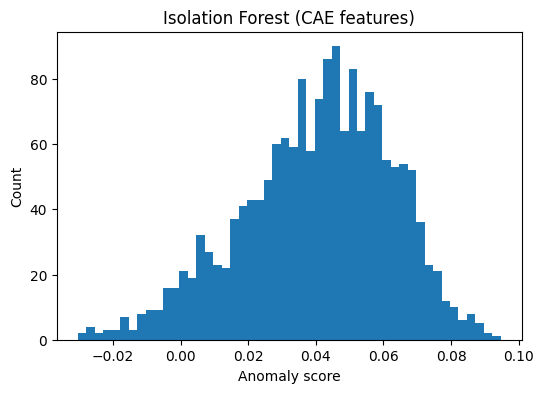

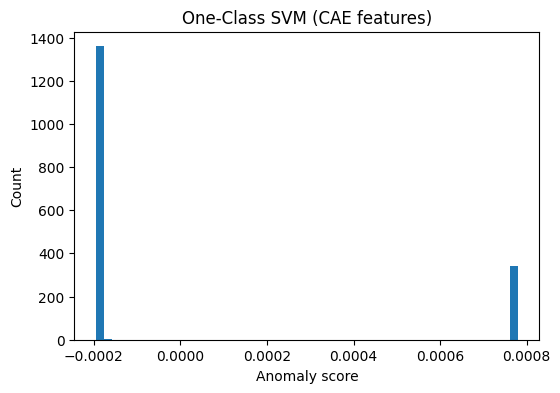

In [ ]:
# Visualization
plot_scores(iso_scores_cae, "Isolation Forest (CAE features)")
plot_scores(svm_scores_cae, "One-Class SVM (CAE features)")


## One-Class Learning Using VAE Latent Features

Latent representations extracted from the trained Variational
Autoencoder (VAE) are used for one-class anomaly detection.

For each paired CT–MRI sample, latent feature vectors are concatenated
to form a joint cross-modal representation.

Combined feature vector:
Feature = [z_CT , z_MRI]

This combined representation is used as input to:

• Isolation Forest  
• One-Class SVM  

In [ ]:
# Extract latent features using VAE model
ct_feat_vae, mri_feat_vae = extract_features(vae_model, train_loader, "vae")

# Combine CT and MRI latent features
combined_features_vae = torch.cat([ct_feat_vae, mri_feat_vae], dim=1)

# Run one-class anomaly detection
iso_scores_vae, iso_labels_vae, svm_scores_vae, svm_labels_vae = \
    run_oneclass_detection(combined_features_vae)


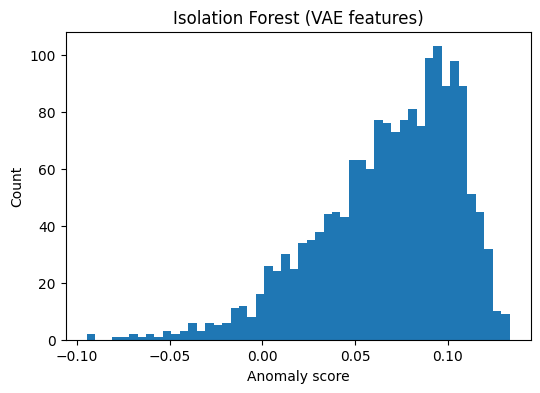

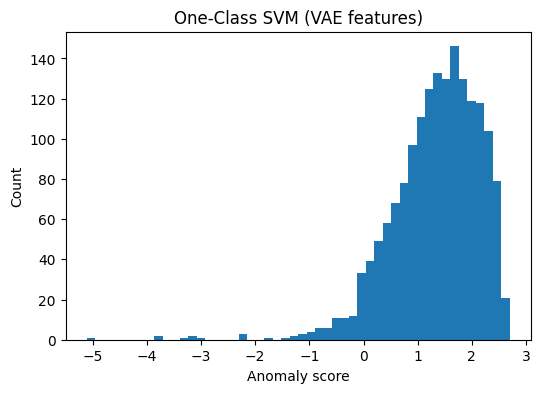

In [ ]:
# Visualization
plot_scores(iso_scores_vae, "Isolation Forest (VAE features)")
plot_scores(svm_scores_vae, "One-Class SVM (VAE features)")


## One-Class Learning Using Transformer Encoder Features

A transformer-based encoder is used to extract global anatomical
representations from CT and MRI images. These latent features are used
for one-class anomaly detection.

For each paired CT–MRI sample, transformer feature vectors are
concatenated to form a joint cross-modal representation.

Combined feature vector:
Feature = [z_CT , z_MRI]

This combined representation is used as input to:

• Isolation Forest  
• One-Class SVM  


In [ ]:
# Extract latent features using Tranformer model
ct_feat_tr, mri_feat_tr = extract_features(trans_model, train_loader, "transformer")

# Combine CT and MRI latent features
combined_features_tr = torch.cat([ct_feat_tr, mri_feat_tr], dim=1)

# Run one-class anomaly detection
iso_scores_tr, iso_labels_tr, svm_scores_tr, svm_labels_tr = \
    run_oneclass_detection(combined_features_tr)


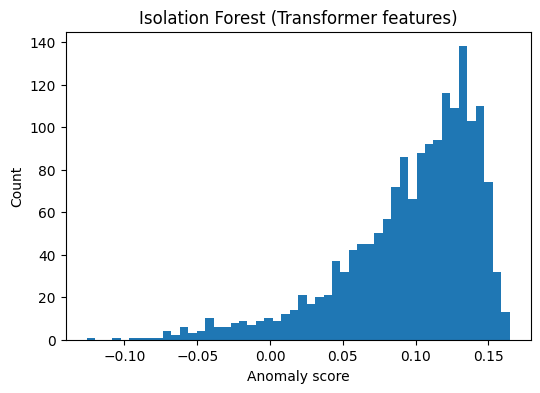

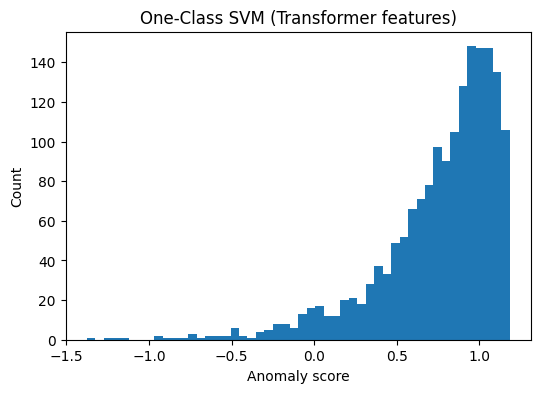

In [ ]:
plot_scores(iso_scores_tr, "Isolation Forest (Transformer features)")
plot_scores(svm_scores_tr, "One-Class SVM (Transformer features)")


## Cross-Modal Latent Divergence

To detect inconsistencies between CT and MRI representations, latent
feature divergence is computed.

Since both modalities correspond to the same anatomical structures,
their latent representations should be similar when trained on normal
data.

Anomaly Score:
Score = || z_CT − z_MRI ||

Large divergence values indicate potential anomalies.

In [ ]:
# Computes cross-modal divergence in latent space.
def cross_modal_divergence(ct_features, mri_features):
    scores = torch.norm(ct_features - mri_features, dim=1)
    return scores


### Cross-Modal Latent Divergence (CAE)

To evaluate consistency between CT and MRI representations learned by
the Convolutional Autoencoder (CAE), cross-modal latent divergence is
computed.

Since CT and MRI images represent the same anatomical structures, their
latent vectors should be similar when the model is trained on normal
data. Large differences between CT and MRI latent representations may
indicate anomalous patterns.

The divergence score is computed as the Euclidean distance between CT
and MRI latent vectors.

Anomaly Score:
Score = || z_CT − z_MRI ||


In [ ]:
# Compute cross-modal divergence using CAE
ct_feat_cae, mri_feat_cae = extract_features(cae_model, train_loader, "cae")
cae_div_scores = cross_modal_divergence(ct_feat_cae, mri_feat_cae)
print(cae_div_scores[:10])


tensor([171.9802, 187.0527, 189.6376, 192.7660, 197.3285, 148.6624, 130.4320,
        133.9883, 135.5025, 149.9371])


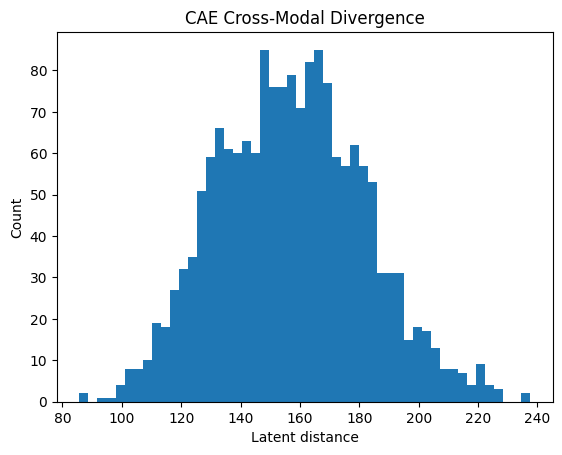

In [ ]:
plt.hist(cae_div_scores.cpu().numpy(), bins=50)
plt.title("CAE Cross-Modal Divergence")
plt.xlabel("Latent distance")
plt.ylabel("Count")
plt.show()


### Cross-Modal Latent Divergence (VAE)

To evaluate cross-modal consistency in the Variational Autoencoder
(VAE), latent divergence between CT and MRI representations is
computed.

For the VAE, the latent representation corresponds to the encoder
output used during feature extraction. Since CT and MRI images represent
the same anatomical structures, their latent vectors should be similar
for normal samples.

The divergence score is computed as the Euclidean distance between CT
and MRI latent vectors.

Anomaly Score:
Score = || z_CT − z_MRI ||


In [ ]:
# Compute cross-modal divergence using VAE
ct_feat_vae, mri_feat_vae = extract_features(vae_model, train_loader, "vae")
vae_div_scores = cross_modal_divergence(ct_feat_vae, mri_feat_vae)
print(vae_div_scores[:10])


tensor([2.0185, 1.0342, 2.5645, 2.6751, 1.7443, 1.8896, 1.9522, 2.6335, 1.4318,
        2.6543])


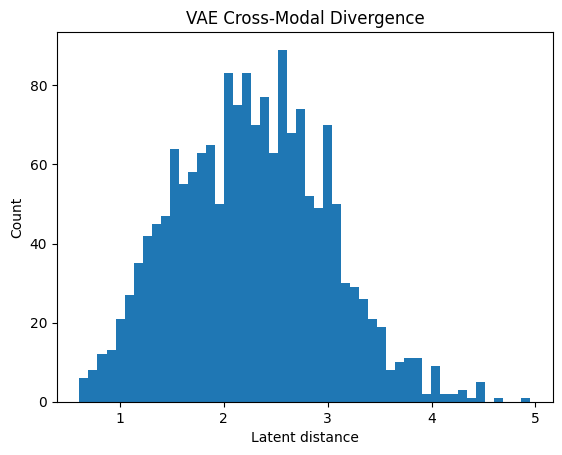

In [ ]:
plt.hist(vae_div_scores.cpu().numpy(), bins=50)
plt.title("VAE Cross-Modal Divergence")
plt.xlabel("Latent distance")
plt.ylabel("Count")
plt.show()


### Cross-Modal Latent Divergence (Transformer Encoder)

To analyze cross-modal consistency using transformer-based features,
latent divergence between CT and MRI representations is computed.

The transformer encoder extracts global anatomical features from both
modalities. Since CT and MRI correspond to the same anatomy, their
feature vectors should be similar for normal samples.

The divergence score is computed as the Euclidean distance between CT
and MRI latent feature vectors.

Anomaly Score:
Score = || z_CT − z_MRI ||

In [ ]:
# Compute cross-modal divergence using Transformer
ct_feat_tr, mri_feat_tr = extract_features(trans_model, train_loader, "transformer")
tr_div_scores = cross_modal_divergence(ct_feat_tr, mri_feat_tr)
print(tr_div_scores[:10])


tensor([5.0900, 4.3653, 5.1528, 5.0482, 3.9871, 5.8164, 4.7867, 4.4050, 5.5927,
        5.4762])


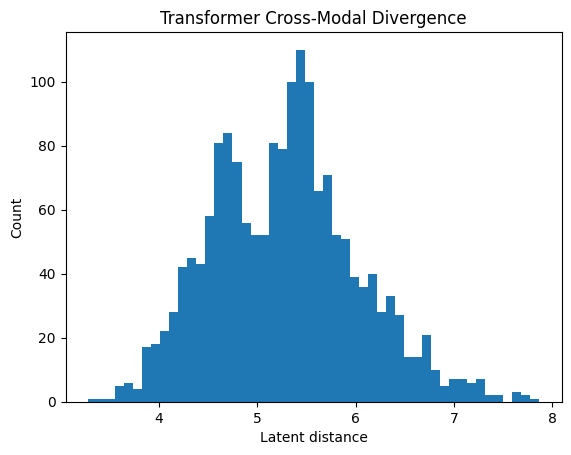

In [ ]:
plt.hist(tr_div_scores.cpu().numpy(), bins=50)
plt.title("Transformer Cross-Modal Divergence")
plt.xlabel("Latent distance")
plt.ylabel("Count")
plt.show()


## Comparison & Evaluation

Since ground-truth anomaly labels are unavailable, evaluation is
performed using reconstruction error distributions, anomaly score
histograms, synthetic anomaly injection, and latent-space analysis.

Synthetic anomalies are created to simulate abnormal patterns and
evaluate detection performance.

### Synthetic Anomaly Injection

Artificial anomalies are introduced by modifying a local region of the
image. This allows validation of anomaly detection performance without
ground-truth labels.


In [ ]:
# Injects a synthetic square anomaly into an image tensor.
def inject_synthetic_anomaly(img, size=32):
    img = img.clone()

    x = np.random.randint(0, img.shape[1] - size)
    y = np.random.randint(0, img.shape[2] - size)

    img[:, x:x+size, y:y+size] = 1.0
    return img


### Generate Normal and Anomalous Samples


In [ ]:


def compute_auc(model, train_loader, device):
    model.eval()
    normal_scores = []
    anomaly_scores = []


    with torch.no_grad():
        for ct, mri in train_loader:
            ct = ct.to(device)
            mri = mri.to(device)

            output_ct = model(ct)
            output_mri = model(mri)

            ct_recon = output_ct[0] if isinstance(output_ct, tuple) else output_ct
            mri_recon = output_mri[0] if isinstance(output_mri, tuple) else output_mri

            ct_err = torch.mean((ct - ct_recon)**2, dim=[1,2,3])
            mri_err = torch.mean((mri - mri_recon)**2, dim=[1,2,3])

            normal_scores.append(ct_err + mri_err)

            ct_anom = inject_synthetic_anomaly(ct[0]).unsqueeze(0).to(device)
            output_ct = model(ct_anom)
            ct_recon = output_ct[0] if isinstance(output_ct, tuple) else output_ct

            ct_err_anom = torch.mean((ct_anom - ct_recon)**2, dim=[1,2,3])

            mri_single = mri[0].unsqueeze(0)
            output_mri = model(mri_single)
            mri_recon = output_mri[0] if isinstance(output_mri, tuple) else output_mri

            mri_err_anom = torch.mean((mri_single - mri_recon)**2, dim=[1,2,3])

            anomaly_scores.append(ct_err_anom + mri_err_anom)

    normal_scores = torch.cat(normal_scores)
    anomaly_scores = torch.cat(anomaly_scores)

    labels = np.concatenate([
        np.zeros(len(normal_scores)),
        np.ones(len(anomaly_scores))
    ])

    scores = np.concatenate([
        normal_scores.cpu().numpy(),
        anomaly_scores.cpu().numpy()
    ])

    auc = roc_auc_score(labels, scores)

    return auc, normal_scores, anomaly_scores


### AUC-ROC Evaluation


In [ ]:
auc_cae, normal_scores_cae, anomaly_scores_cae = compute_auc(cae_model, train_loader, device)

print("CAE AUC-ROC:", auc_cae)

auc_vae, normal_scores_vae, anomaly_scores_vae = compute_auc(cae_model, train_loader, device)

print("VAE AUC-ROC:", auc_vae)


CAE AUC-ROC: 0.5199934223147971
VAE AUC-ROC: 0.501257982295064


### Mean Reconstruction Error


In [ ]:

print("Mean reconstruction error:", normal_scores_cae.mean().item())
print("Mean reconstruction error:", normal_scores_vae.mean().item())


Mean reconstruction error: 0.5786083936691284
Mean reconstruction error: 0.5773711204528809


### Latent Space Distance Measures


In [ ]:
print("CAE latent divergence mean:", cae_div_scores.mean().item())
print("VAE latent divergence mean:", vae_div_scores.mean().item())
print("Transformer latent divergence mean:", tr_div_scores.mean().item())


CAE latent divergence mean: 157.05784606933594
VAE latent divergence mean: 2.2715237140655518
Transformer latent divergence mean: 5.284219264984131


### Reconstruction Error Distribution


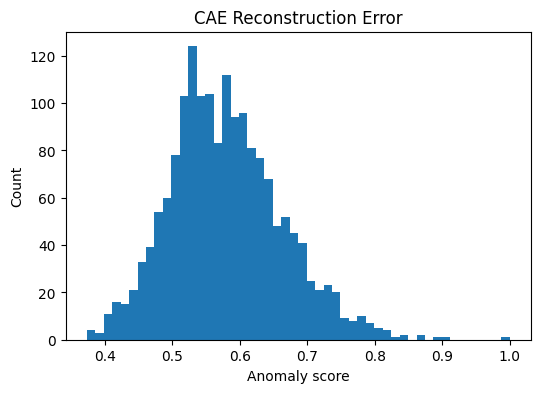

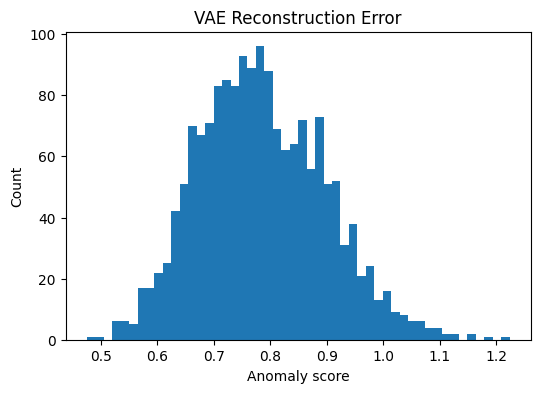

In [ ]:
plot_scores(cae_recon_scores.numpy(), "CAE Reconstruction Error")
plot_scores(vae_recon_scores.numpy(), "VAE Reconstruction Error")


### Qualitative Visual Inspection of Anomaly Maps

Anomaly maps are created using pixel-wise reconstruction error.


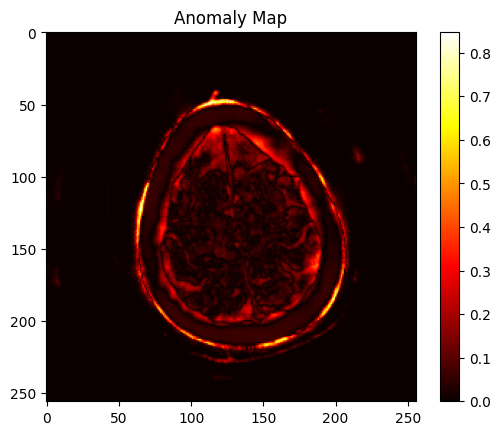

In [ ]:
ct, _ = next(iter(train_loader))
# Perform reconstruction using trained CAE model
with torch.no_grad():
    ct_recon, _ = cae_model(ct)

# Compute absolute reconstruction error
error_map = torch.abs(ct - ct_recon)

# Visualize
plt.imshow(error_map[0, 0].detach().cpu().numpy(), cmap="hot")
plt.title("Anomaly Map")
plt.colorbar()
plt.show()


## Analysis

### 1. Reconstruction-Based Analysis
- The reconstruction error histograms show the distribution of anomaly scores learned by the models.  
- The mean reconstruction error for both models is approximately **0.57–0.58**, indicating that both models reconstruct normal images to a similar extent.

- The anomaly map highlights regions where model struggels to reconstruct in brighter colors. These regions indicate potential anomalies or reconstruction inconsistencies.

### 2. AUC-ROC Comparison
The obtained AUC-ROC scores are:
- **CAE AUC-ROC: 0.52**
- **VAE AUC-ROC: 0.50**
An AUC value close to **0.5** indicates limited separation between normal and synthetic anomalous samples.
Since the framework is fully unsupervised and relies on synthetic anomaly injection, moderate performance is expected.

### 3. Latent Divergence Comparison
The mean latent divergence values are:
- **CAE: 157.05**
- **VAE: 2.27**
- **Transformer: 5.28**

From these values, we can see that the CAE model has very high latent divergence, which means the CT and MRI features are not well aligned in the latent space.  

On the other hand, the VAE and Transformer models have much lower divergence values, which indicates better alignment between CT and MRI representations.

This shows that the VAE learns more stable and consistent shared representations across both modalities compared to the CAE model.

